In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Loading Data

In [2]:
data = pd.read_csv('./amazon-fine-food-reviews/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.shape

(568454, 10)

In [4]:
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite')

In [5]:
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 LIMIT 5000""",con)

def partition(x):
    if x>3:
        return 1
    return 0

actual_score = filtered_data['Score']
positive_negative = actual_score.map(partition)
filtered_data['Score'] = positive_negative
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
filtered_data.shape

(5000, 10)

## EDA

In [7]:
display = pd.read_sql_query("""SELECT ProductId UserId, ProfileName, Score, Time, COUNT(*)
FROM Reviews GROUP BY UserId HAVING COUNT(*) > 1""",con)
display.head()

,UserId,ProfileName,Score,Time,COUNT(*)
0,B005ZBZLT4,Breyton,2,1331510400,2
1,B005HG9ESG,"Louis E. Emory ""hoppy""",5,1342396800,3
2,B005ZBZLT4,Kim Cieszykowski,1,1348531200,2
3,B005HG9ESG,Penguin Chick,5,1346889600,3
4,B007OSBEV0,Christopher P. Presta,1,1348617600,2


In [8]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, inplace=False, ascending=True, kind='quicksort', na_position='last')
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [9]:
final_data = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'}, inplace=False, keep='first')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [10]:
final_data = final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
final_data.shape

(4986, 10)

In [11]:
final_data['Score'].value_counts()

1    4178
0     808
Name: Score, dtype: int64

## Text Preprocessing

In [12]:
sent_0 = final_data['Text'].values[2]
print(sent_0)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.


In [13]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [15]:
from bs4 import BeautifulSoup
from tqdm import tqdm

preprocessed_reviews = [];
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", '',sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", '', sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+',' ', sentence)
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence)

100%|██████████| 4986/4986 [00:02<00:00, 2122.60it/s]


In [16]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

## BoW

In [23]:
count_vect = CountVectorizer()
#count_vect.fit(preprocessed_reviews)
final_counts_bow = count_vect.fit_transform(preprocessed_reviews)
final_counts_bow.shape

(4986, 12997)

In [51]:
final_counts_bow[1500]

<1x12997 sparse matrix of type '<class 'numpy.int64'>'
	with 87 stored elements in Compressed Sparse Row format>

## n-gram

In [53]:
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_counts_ngram = count_vect.fit_transform(preprocessed_reviews)
final_counts_ngram.shape

(4986, 3144)

In [55]:
final_counts_ngram[1500]

<1x3144 sparse matrix of type '<class 'numpy.int64'>'
	with 93 stored elements in Compressed Sparse Row format>

## TF-IDF

In [62]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_counts_tfidf = tfidf_vect.fit_transform(preprocessed_reviews)
final_counts_tfidf.shape

(4986, 3144)

## Word2Vec

In [45]:
list_sentences = []
for sentence in preprocessed_reviews:
    list_sentences.append(sentence)

In [46]:
w2v_model = Word2Vec(list_sentences, min_count=5, size=50, workers=5) 
w2v_words = w2v_model.wv.vocab

### Avg W2V

In [57]:
sentence_vectors = []

for sent in list_sentences:
    sent_vec= np.zeros(50)
    count=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            count += 1
    if count != 0:
        sent_vec /= count
        sentence_vectors.append(sent_vec)
sentence_vectors[0]

array([ 0.06236839,  0.006444  , -0.00602274,  0.08543117, -0.00036233,
       -0.10173233,  0.02114773,  0.07518299,  0.00033294,  0.03275717,
       -0.13606381, -0.03470378, -0.10725108,  0.09051213, -0.03980331,
       -0.17293535, -0.16619731,  0.05233296,  0.00492194,  0.03151981,
        0.05433822,  0.08578509,  0.04258692, -0.12847487, -0.01977851,
       -0.13574889,  0.09231375, -0.00075991,  0.06998853,  0.0548945 ,
        0.11632348, -0.14727498, -0.11530445,  0.02342418, -0.04823948,
        0.1584318 , -0.04063123,  0.16923704,  0.11440124,  0.13357735,
        0.05643728,  0.06366849,  0.06541976,  0.01148825,  0.08383394,
       -0.00609922, -0.05503511,  0.10258442, -0.00901296,  0.09832863])

### TF_IDF W2V

## TSNE on BOW

In [28]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

In [31]:
final = csr_matrix.todense(final_counts_bow)
standardized_bow_data = StandardScaler().fit_transform(final)
standardized_bow_data.shape

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4986, 12997)

In [32]:
from sklearn.manifold import TSNE

In [36]:
data_sample = standardized_bow_data[0:5000,:]
label_sample = final_data['Score'][0:5000]
label_sample.head(5)

2546    1
2547    1
1145    1
1146    1
2942    1
Name: Score, dtype: int64

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


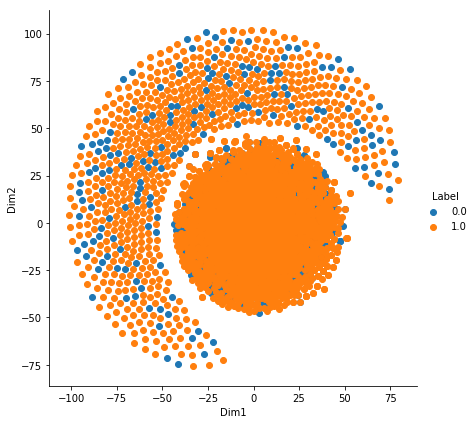

In [39]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


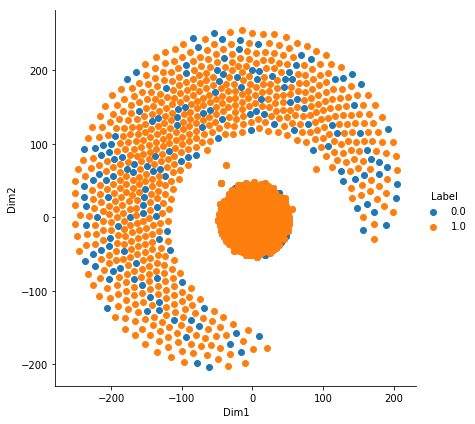

In [41]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


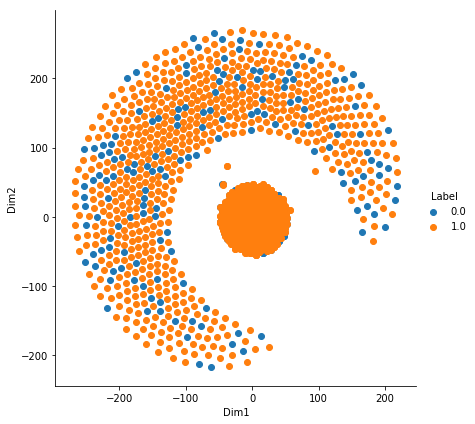

In [42]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=7000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


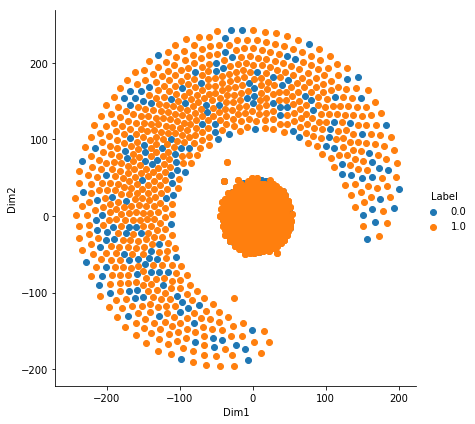

In [43]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

## TSNE on n-gram

In [58]:
final = csr_matrix.todense(final_counts_ngram)
standardized_ngram_data = StandardScaler().fit_transform(final)
standardized_ngram_data.shape

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4986, 3144)

In [74]:
data_sample = standardized_ngram_data[0:5000,:]
label_sample = final_data['Score'][0:5000]
data_sample[0]

array([-0.04249502, -0.15459382, -0.07149649, ..., -0.12106305,
       -0.06090338, -0.04579682])

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


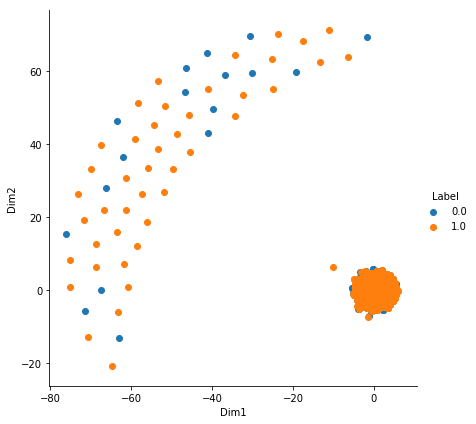

In [60]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

## TSNE on TFIDF

In [63]:
final = csr_matrix.todense(final_counts_tfidf)
standardized_ngram_data = StandardScaler().fit_transform(final)
standardized_ngram_data.shape

(4986, 3144)

In [64]:
data_sample = standardized_ngram_data[0:5000,:]
label_sample = final_data['Score'][0:5000]
label_sample.head(5)

2546    1
2547    1
1145    1
1146    1
2942    1
Name: Score, dtype: int64

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


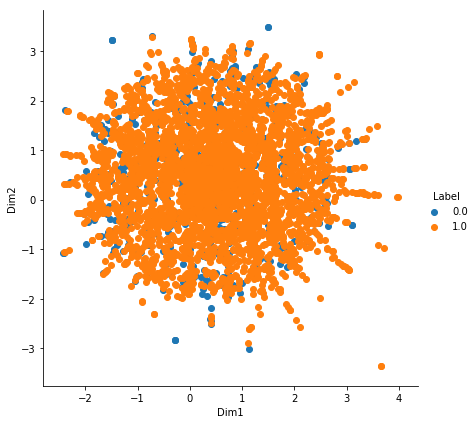

In [65]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()

## TSNE on Words2Vector

In [77]:
standardized_w2v_data = StandardScaler().fit_transform(sentence_vectors)
standardized_w2v_data.shape

(4971, 50)

In [78]:
data_sample = standardized_w2v_data[0:4000,:]
label_sample = final_data['Score'][0:4000]
label_sample.shape

(4000,)

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


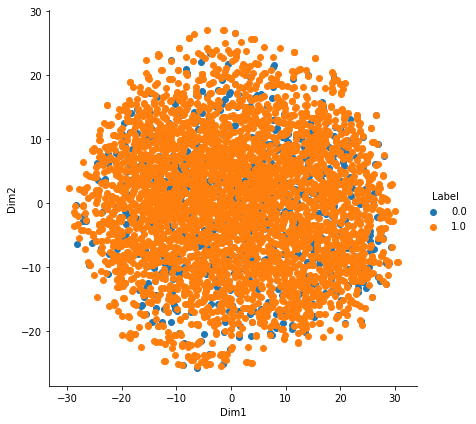

In [79]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=5000)
tsne_data = tsne_model.fit_transform(data_sample)

tsne_data = np.vstack((tsne_data.T, label_sample)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim1','Dim2','Label'))

sns.FacetGrid(tsne_df, hue='Label', size=6).map(plt.scatter, 'Dim1','Dim2').add_legend()